In [1]:
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils

import numpy as np
import matplotlib.pyplot as plt
import csv

import rn_loader

In [2]:
# hyperparams
epochs = 10
ngf = 128            # render net feature map size
batch_size = 128

# global vars
dataroot = "data/"   # root directory for training data
image_size = 128     # training image size
workers = 0          # number of dataloader workers
ngpu = 1             # number of gpus to use
nc = 3               # number of color channels in the input image


In [3]:
# load dataset
rnet_dataset = rn_loader.RenderNetDataset(csv_file='data/labels.csv',
                                          root_dir='data/judkins_box',
                                          transform=transforms.Compose([
                                              transforms.ToPILImage(),
                                              transforms.Resize(image_size),
                                              transforms.CenterCrop(image_size),
                                              transforms.ToTensor(),
                                              transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                                          ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(rnet_dataset, batch_size=batch_size, shuffle=True, num_workers=workers)

In [4]:
# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
print("Using device ", device)

Using device  cuda:0


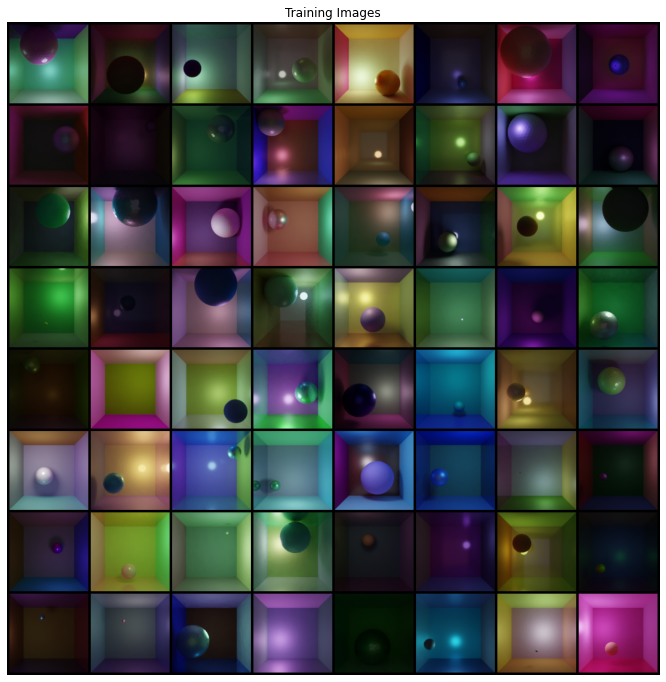

In [5]:
# Plot some training images
data_iter = iter(dataloader)

data = data_iter.next()

plt.figure(figsize=(12,12))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(data['image'].to(device)[:64], padding=4, normalize=True).cpu(),(1,2,0)))
plt.show()

In [6]:
# load the labels csv
labels = []
with open('data/labels.csv') as labels_file:
    reader = csv.reader(labels_file)
    for row in reader:
        labels.append(row)

scene_size = len(labels[0])
print("scene vector size: " + str(scene_size))

scene vector size: 44


In [7]:
# RenderNet

class RenderNet(nn.Module):
    def __init__(self, ngpu):
        super(RenderNet, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(scene_size, ngf * 16, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 16),
            nn.ReLU(True),
            # state size. (ngf*16) x 4 x 4
            nn.ConvTranspose2d(ngf * 16, ngf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 8 x 8
            nn.ConvTranspose2d( ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 16 x 16
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 32 x 32
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 64 x 64
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh(),
            nn.ReLU(True)
            # state size. (nc) x 128 x 128
        )

    def forward(self, input):
        return self.main(input)

In [8]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [9]:
# Create the render network
rnet = RenderNet(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    rnet = nn.DataParallel(rnet, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
rnet.apply(weights_init)

# Print the model
print(rnet)

RenderNet(
  (main): Sequential(
    (0): ConvTranspose2d(44, 2048, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(2048, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Bat

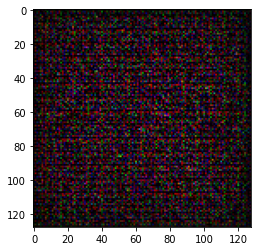

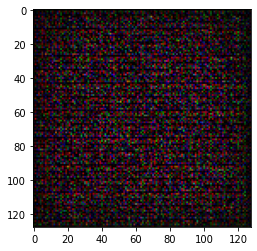

In [10]:
for i in range(1,3):
    scene_vec = torch.FloatTensor([float(ele) for ele in labels[i]]).to('cuda')
    nn_input = scene_vec.view(1, scene_size, 1, 1)

    fake = rnet(nn_input).detach().cpu()
    img = np.transpose(torch.squeeze(fake), (1,2,0))

    plt.imshow(img)
    plt.show()
    plt.imsave('untrained.png', arr=img.numpy())

In [11]:
# training loop
for e in range(epochs):
    print("Epoch #%d" % e)
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):


SyntaxError: unexpected EOF while parsing (<ipython-input-11-7d0b2bb399a2>, line 5)

In [ ]:
foo = torch.randn(2, 4, 1, 1)
print(foo)